In [1]:
library(Seurat)
library(ggplot2)
library(readxl)
library(ggsci)
library(cowplot)
library(stringr)
library(ggrepel)
library(tidyverse)
library(data.table)
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
#library(harmony)
# categorical palette
d3_20 = pal_d3("category20")(20)
npg_9 = pal_npg()(9)
aaas_9 = pal_aaas()(9)
zeileis_28 = c(
                "#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#4a6fe3",
                "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", "#11c638", "#8dd593",
                "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7",
                "#f3e1eb", "#f6c4e1", "#f79cd4", '#7f7f7f', "#c7c7c7", "#1CE6FF", "#336600")
clustercols <- readRDS("colorList.rds")
set.seed(123)

Attaching SeuratObject

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [3]:
srt_subset <- readRDS("srt_subset_lung_NEW.rds")

In [4]:
dim(srt_subset)
unique(srt_subset$`celltype_res0.4`)

[1] 25594 25622

[1] Alveolar fibroblast   Club cells            PNEC                 
 [4] IM                    ATII                  Neutrophil           
 [7] Th17                  Lymphatic EC          Ciliated cells       
[10] ATII 2                Alveolar fibroblast 2 Mesothelial          
[13] Endothelial 2         Th1                   B cell               
[16] Endothelial           NK cell               Airway SMC           
[19] DC1                   Naive T               AM                   
[22] Club cells 2          Monocyte              Gata3+ ILC2          
[25] ATI                   Dividing AM           Proliferating T      
27 Levels: Dividing AM IM Alveolar fibroblast Club cells ... ATI

In [20]:
clustcolfinal <- clustercols[-c(18:27)][1:length(unique(srt_subset$`celltype_res0.4`))]
names(clustcolfinal) <- unique(srt_subset$`celltype_res0.4`)

In [5]:
markers <- fread("variable_markers_clust_res0.4_NEW.csv")

In [8]:
top5 <- markers %>% group_by(cluster) %>% top_n(n = 4, wt = avg_log2FC)
head(top5)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
0.000000e+00,1.091157,0.861,0.811,0.000000e+00,0,Cst3
0.000000e+00,1.060309,0.717,0.472,0.000000e+00,0,H2-Eb1
1.518845e-193,1.063481,0.434,0.228,4.903592e-189,0,Ccl6
4.453065e-117,1.095146,0.314,0.178,1.437672e-112,0,Cd83
0.000000e+00,2.201610,0.959,0.444,0.000000e+00,1,Mgp
0.000000e+00,2.200808,0.646,0.169,0.000000e+00,1,Inmt


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 6800 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 6800 rows containing missing values (`geom_point()`).”


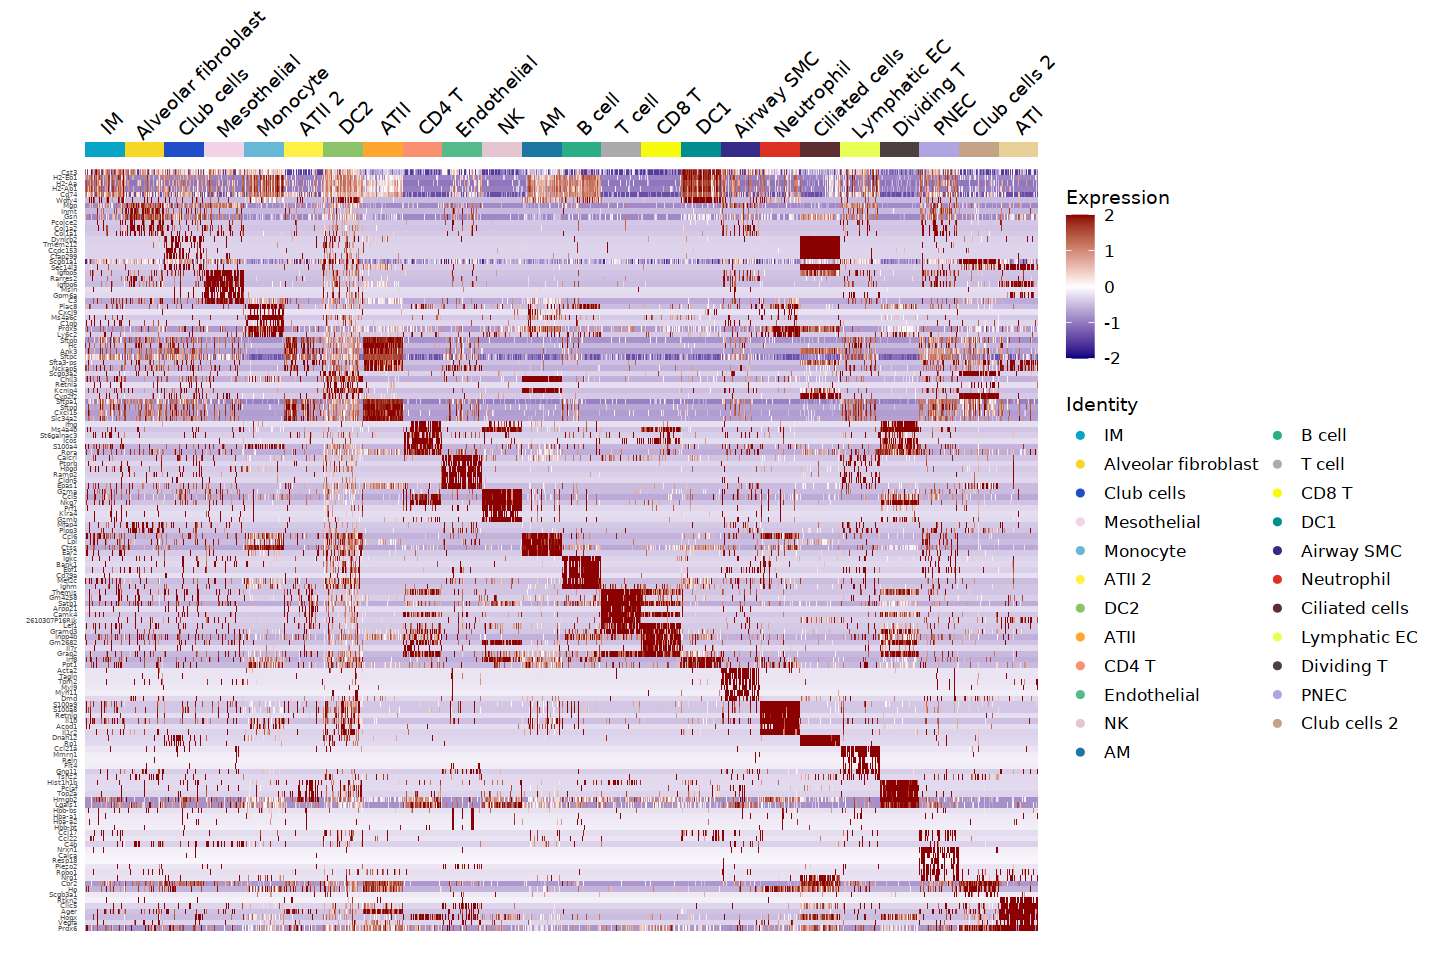

In [25]:
# Plot heatmap of FindAllMarkers for each cluster
height = 8
width= 12
options(repr.plot.width=width, repr.plot.height=height, repr.plot.res = 120)
# mapal <- colorRampPalette(RColorBrewer::brewer.pal(11,"RdBu"))(256)
tt= DoHeatmap(subset(srt_subset, downsample = 50), features = top5$gene, 
               group.by = "celltype_res0.4",
               group.bar = TRUE,
               group.colors = clustcolfinal,
               label = TRUE,
               size = 4,
               hjust = 0.05,
               angle = 45,
               raster = TRUE,
               draw.lines = FALSE,
             ) 
tt = tt+ scale_fill_gradientn(colours=c("navyblue", "white", "darkred"), limits = c(-2,2), oob = scales::squish) +
      theme(axis.text.y=element_text(size = 4, face="bold"), 
            #axis.text.x=element_text(face="bold"), 
            legend.text=element_text(size=10))  

tt

ggplot2::ggsave(plot = tt, filename = paste0("srt_lung_top6_markers_heatmap.pdf"), 
                device = 'pdf', width = width, height = height,  units = "in", dpi=300)
#ggplot2::ggsave(plot = tt, filename = paste0("Results/diffexp/top5.markers.heatmap.jpg"), 
 #               device = 'jpeg', width = width, height = height,  units = "in", dpi=300)

In [9]:
# Plot average expression of FindAllMarkers for each cluster
tmp = AverageExpression(srt_subset, group.by="celltype_res0.4", features = top5$gene, slot = 'data')$RNA
# colnames(tmp) = str_c("C", colnames(tmp))

In [34]:
head(tmp)

,IM,Alveolar fibroblast,Club cells,Mesothelial,Monocyte,ATII 2,DC2,ATII,CD4 T,Endothelial,⋯,CD8 T,DC1,Airway SMC,Neutrophil,Ciliated cells,Lymphatic EC,Dividing T,PNEC,Club cells 2,ATI
Cst3,65.245354,39.5049163,26.199173,31.993257,30.336765,8.588059,40.990880,3.571182,1.69187588,15.3096213,⋯,0.90996654,228.29949,36.3728529,16.541254,3.9687513,37.5800441,2.4544998,37.076438,2.9280374,6.9121646
H2-Eb1,21.174183,3.9512429,6.745362,5.948428,38.270425,3.141928,17.283830,4.683985,0.37960314,3.9516323,⋯,0.19874476,59.38922,8.9997254,6.852331,1.3912037,12.1904372,0.3554629,11.974315,0.8993615,1.0022105
H2-Aa,25.613432,5.4115907,9.455058,8.517643,41.823662,5.978942,22.075273,11.108987,0.44063230,5.2326990,⋯,0.26485598,57.47071,10.7970269,8.203411,2.0091439,15.1260284,0.2723336,14.100928,1.3159523,1.4144227
H2-Ab1,23.276139,4.5603605,7.621075,7.522124,41.151772,4.390479,18.906072,8.391285,0.44813640,4.5359704,⋯,0.24179342,62.20931,11.1245344,7.805042,1.7403787,12.2319948,0.3641501,12.479263,1.1329807,1.6201074
Cd74,74.607354,17.3417089,28.414212,26.954991,120.176591,23.756835,55.235224,45.493464,1.18759208,16.8482294,⋯,0.70584540,170.08649,34.6951043,23.532022,7.2762218,47.2321824,1.0580410,50.802497,7.3542654,8.5847198
Wdfy4,4.146063,0.9307555,1.208030,1.056130,1.381506,0.336029,3.722551,0.028252,0.02337531,0.2872097,⋯,0.01032912,19.31569,0.7346592,2.062075,0.0314604,0.9081302,0.0321591,1.472969,0.1380967,0.0110051


png 
  2

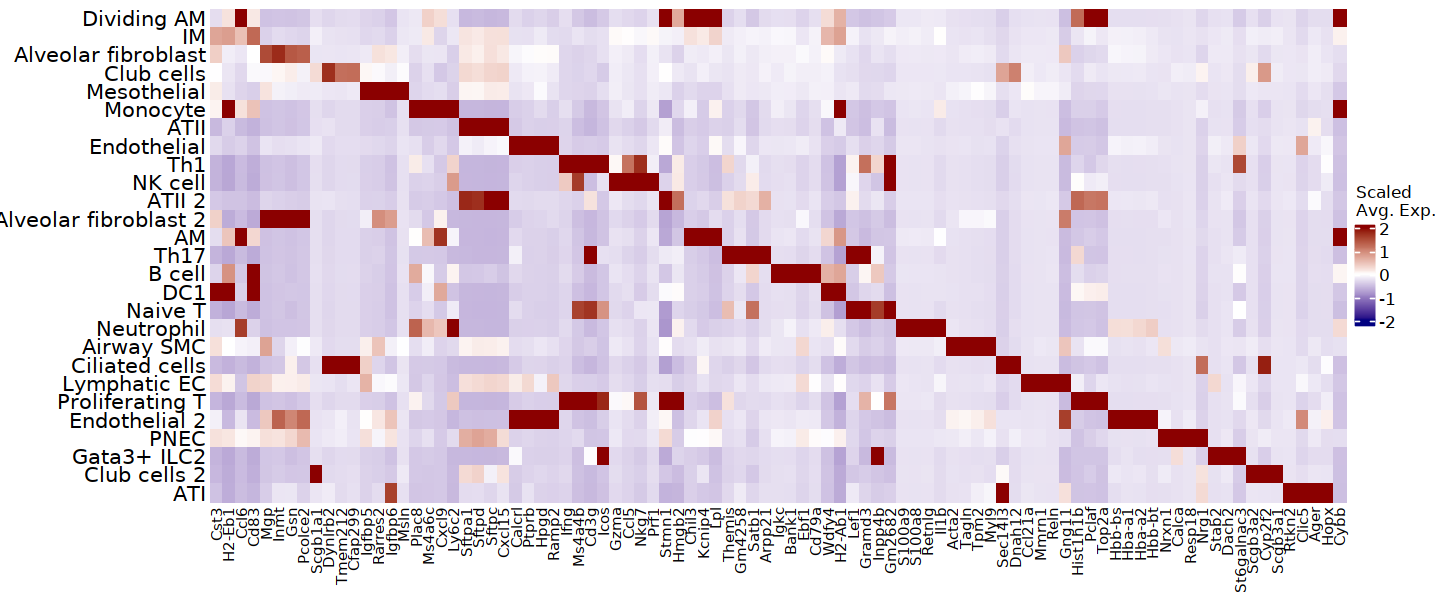

In [14]:
width = 12
height = 5
#library(scales)
options(repr.plot.width=width, repr.plot.height=height)
col_fun = circlize::colorRamp2(c(-2, 0, 2), c("navyblue", "white", "darkred"))

ht = Heatmap(scale(t(tmp)), name="Scaled \nAvg. Exp.", col=col_fun,
             cluster_rows = FALSE,
             cluster_columns = FALSE, 
             column_names_side = 'bottom',
             row_names_side="left",
             column_names_rot = 90,
             column_names_gp = gpar(fontsize = 8.5, fontface = "bold"),
             row_names_gp = gpar(fontsize = 12, fontface = "bold"),
             # rect_gp = gpar(col = "white", lwd = 2),
             # cell_fun = function(j, i, x, y, w, h, col) { # add text to each grid
             # grid.text(scales::percent(cellpct[i, j], 0.01), x, y)}
            )

draw(ht)
pdf(paste0("top5_markers_heatmap_avg.pdf"), width = width, height = height)
draw(ht)
dev.off()

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


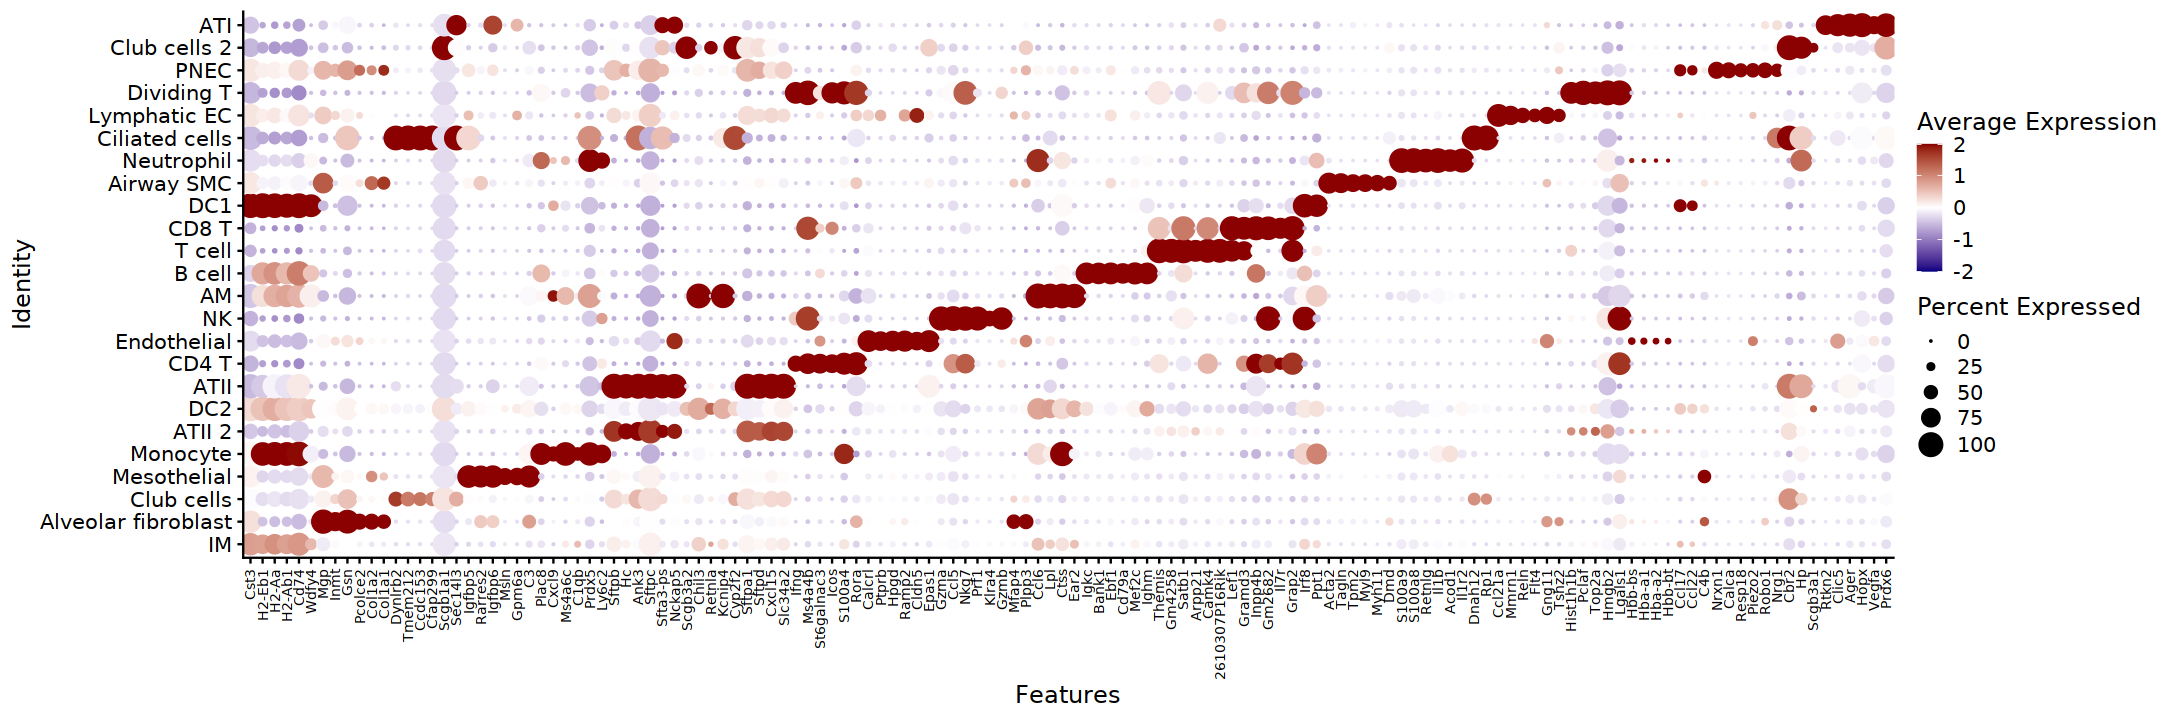

In [49]:
# Plot bubble plot
height = 6
width=18
features = unique(top5$gene)
options(repr.plot.width=width, repr.plot.height=height, repr.plot.res = 120)
# p = VlnPlot(srt_ko, features = c("Ldlr", "BNT162b2"), group.by="annot.celltype3", 
#             ncol=1, 
#             split.by = "condition", raster = T) 
p = DotPlot(srt_subset, features = features, group.by = "celltype_res0.4")
p = p +#= #p + scale_x_discrete(labels=gene_annot[features,'gene_name']) + xlab("") + ylab("Clusters")+
    scale_color_gradientn(colours=c("navyblue", "white", "darkred"), limits = c(-2,2), oob = scales::squish) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size=8)) 
print(p)

ggplot2::ggsave(plot = p, filename = paste0("top5_markers_dotplot.pdf"), 
                device = 'pdf', width = width, height = height,  units = "in", dpi=300)


In [3]:
# Plot number of DEGs plot
degs_updw <- fread("lung_fc0.25_pct0.1_D21vsD0_DEG_NEW.csv")

In [42]:
unique(degs_updw$celltype)
head(degs_updw)

[1] "Alveolar fibroblast"   "Club cells"            "IM"                   
 [4] "ATII"                  "Neutrophil"            "Th17"                 
 [7] "Lymphatic EC"          "Ciliated cells"        "ATII 2"               
[10] "Alveolar fibroblast 2" "Mesothelial"           "Th1"                  
[13] "B cell"                "Endothelial"           "NK cell"              
[16] "Airway SMC"            "DC1"                   "Naive T"              
[19] "AM"                    "Club cells 2"          "Monocyte"             
[22] "Gata3+ ILC2"           "ATI"                   "Dividing AM"          
[25] "Proliferating T"

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene,cell1,cell2,contrast1,contrast2,celltype
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1.343655e-212,3.985769,0.71,0.032,3.438950e-208,Iigp1,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.169451e-147,3.968743,0.23,0.001,2.993093e-143,Cxcl9,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.537684e-133,2.352099,0.43,0.017,3.935548e-129,Igtp,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
6.817292e-133,5.737726,0.23,0.002,1.744818e-128,Saa3,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.574755e-129,2.096323,0.33,0.009,4.030429e-125,Gbp6,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast
1.318522e-128,1.750790,0.19,0.001,3.374625e-124,Serpina3f,100,3556,Alveolar fibroblast_D21,Alveolar fibroblast_D0,Alveolar fibroblast


In [4]:
degs_updw$updown <- ifelse(degs_updw$avg_log2FC > 0, "UP", "DOWN")

In [5]:
celltype_order <- c("ATII", "ATII 2", "ATI","Ciliated cells","Club cells", "Club cells 2", "Endothelial", "Lymphatic EC", "Mesothelial",
                    "Alveolar fibroblast", "Alveolar fibroblast 2", "Airway SMC","AM", "Dividing AM", "IM","Monocyte","Neutrophil","DC1", 
                    "Naive T", "Th1","Th17","Proliferating T","NK cell","B cell", "Gata3+ ILC2")

In [6]:
degs_updw_sig <- degs_updw %>% dplyr::filter(p_val_adj <0.05)
dim(degs_updw_sig)

[1] 10634    12

In [7]:
degs_num = degs_updw_sig %>% group_by(celltype) %>% count(updown)
degs_num$updown = factor(degs_num$updown, levels = c("UP", "DOWN")) 
degs_num$celltype = factor(degs_num$celltype, levels = rev(celltype_order))

In [8]:
degs_num

celltype,updown,n
<fct>,<fct>,<int>
AM,DOWN,476
AM,UP,395
ATI,UP,4
ATII,DOWN,102
ATII,UP,162
ATII 2,DOWN,67
ATII 2,UP,1368
Airway SMC,DOWN,4
Airway SMC,UP,191


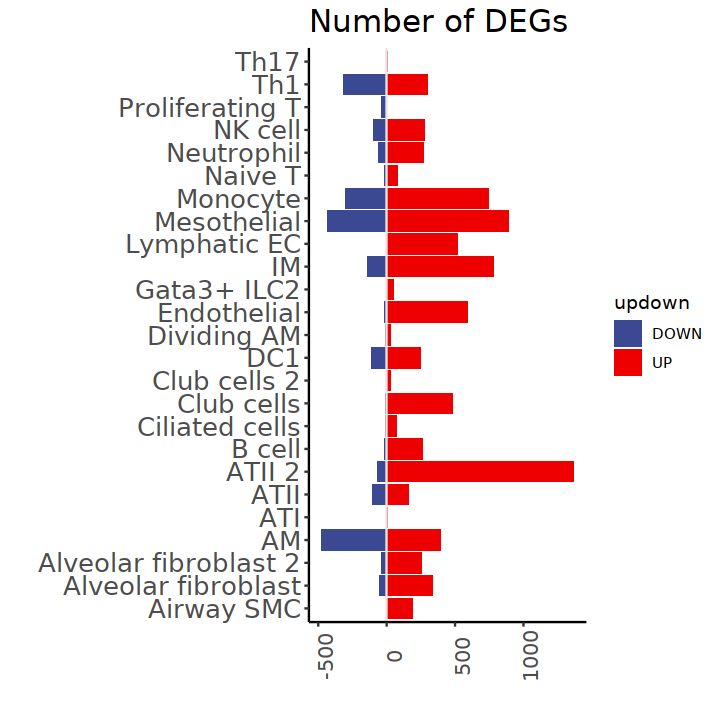

In [9]:
height = 6
width= 6
options(repr.plot.width=width, repr.plot.height=height, repr.plot.res = 120)

## Using your df.m data frame
p = ggplot(degs_num, aes(celltype)) + 
geom_bar(data = subset(degs_num, updown == "UP"), 
   aes(y = n, fill = updown), stat = "identity", position = "dodge") +
geom_bar(data = subset(degs_num, updown == "DOWN"), 
   aes(y = -n, fill = updown), stat = "identity", position = "dodge") + 
geom_hline(yintercept = 0,colour = "grey90") + coord_flip()+
scale_fill_aaas() + theme_classic()+
    ylab("") + xlab("")+
    theme(axis.text.x = element_text(size=12, angle=90), 
          axis.text.y = element_text(size=15), 
          strip.text.x = element_text(size = 14, color = "black", face = "bold"), # per ax title
          plot.title = element_text(size = 18, face = "bold"),
          axis.title=element_text(size=15,face="bold")) + ggtitle("Number of DEGs")

print(p)

# ggplot2::ggsave(plot = p, filename = paste0("degs_num_plot.pdf"), 
#                 device = 'pdf', width = width, height = height,  units = "in", dpi=300)

# ggplot2::ggsave(plot = p, filename = paste0(paste0("Results/diffexp/degs.num.jpg")), 
#                 device = 'jpeg', width = width, height = height,  units = "in", dpi=300)

# last_plot() + 
#    geom_text(data = subset(df.m, variable == "count.up"), 
#       aes(strain, value, group=condition, label=value),
#         position = position_dodge(width=0.9), vjust = 1.5, size=4) +
#     geom_text(data = subset(df.m, variable == "count.down"), 
#       aes(strain, -value, group=condition, label=value),
#         position = position_dodge(width=0.9), vjust = -.5, size=4) +
#     coord_cartesian(ylim = c(-500, 500))

In [10]:
dim(srt_subset)
table(srt_subset$source_tp)

ERROR: Error in eval(expr, envir, enclos): object 'srt_subset' not found


In [14]:
# Perform GSEA
srt_subset_noribo <- srt_subset[grep("^Rp[sl][[:digit:]]|^Rplp[[:digit:]]|^Rpsa|^mt-", rownames(srt_subset), value = T, invert = T), ]
dim(srt_subset_noribo)
dim(srt_subset)

[1] 25480 25622

[1] 25594 25622

In [13]:
## hypogemetric analysis
background_gene = rownames(srt_subset)
background_gene = grep("^Rp[sl][[:digit:]]|^Rplp[[:digit:]]|^Rpsa|^mt-", background_gene, value=T, invert = T)
btm_mouse_df = as.data.frame(read_rds("GMT/bloodtranscriptionalmodules.mouse.clusterprofiler.gmt.rds"))
btm_mouse_df = btm_mouse_df[!startsWith(btm_mouse_df$term, "TBA"),]

In [14]:
suppressMessages(library(clusterProfiler))

In [155]:
## Enrichment For 1 cell type
# key <- unique(degs_updw$celltype)[1]
# key
# df = degs_updw %>% dplyr::filter(celltype == key)
# dim(df)
# df = df[grep("^Rp[sl][[:digit:]]|^Rplp[[:digit:]]|^Rpsa|^mt-", df$gene, invert = T),]
# dim(df)
# df$updown <- ifelse(df$avg_log2FC > 0, "UP Genes", "DOWN Genes")
# df_up <- enricher(df[df$updown == "UP Genes", "gene"]$gene, TERM2GENE=btm_mouse_df, universe=background_gene, minGSSize = 5, maxGSSize = 1000) 
#  df_dw <- enricher(df[df$updown == "DOWN Genes", "gene"]$gene, TERM2GENE=btm_mouse_df,   universe=background_gene, minGSSize = 5, maxGSSize = 1000)  
#    df_up = as.data.frame(df_up)
#        df_dw = as.data.frame(df_dw)
#   if (nrow(df_up) > 0) {
#            df_up$clust = unique(df$celltype)
#            df_up$updown = "UP Genes"
#         }
#       if (nrow(df_dw) > 0) {
#            df_dw$clust = unique(df$celltype)
#            df_dw$updown = "DOWN Genes"
#           }
# enrich = rbind(df_up, df_dw)
# enrich <- enrich[which(enrich$pvalue < 0.05),]
# dim(enrich)

[1] 1453   12

[1] 1436   12

In [15]:
## hypogemetric analysis on DEG df
degs_updw <- fread("lung_fc0.25_pct0.1_D21vsD0_DEG_NEW.csv")
all_updw_enrich = list()
for (key in unique(degs_updw$celltype))  {  
       df = degs_updw %>% dplyr::filter(celltype == key)
    print(key)
       #df = asymptomatic.deg.list[['C1 - NK__Asymptomatic.vs.Healthy']]
       df = df[grep("^Rp[sl][[:digit:]]|^Rplp[[:digit:]]|^Rpsa|^mt-", df$gene, invert = T),]
       df$updown <- ifelse(df$avg_log2FC > 0, "UP Genes", "DOWN Genes")
       df_up <- enricher(df[df$updown == "UP Genes", "gene"]$gene, TERM2GENE=btm_mouse_df, universe=background_gene, minGSSize = 5, maxGSSize = 1000,) 
       df_dw <- enricher(df[df$updown == "DOWN Genes", "gene"]$gene, TERM2GENE=btm_mouse_df,   universe=background_gene, minGSSize = 5, maxGSSize = 1000,)  
       df_up = as.data.frame(df_up)
       df_dw = as.data.frame(df_dw)
       if (nrow(df_up) > 0) {
           df_up$clust = unique(df$celltype)
           df_up$updown = "UP Genes"
        }
      if (nrow(df_dw) > 0) {
           df_dw$clust = unique(df$celltype)
           df_dw$updown = "DOWN Genes"
       }
       enrich = rbind(df_up, df_dw)
       enrich <- enrich[which(enrich$pvalue < 0.05),]   #get only significant modules
       # y <- clusterProfiler::GSEA(geneList, TERM2GENE=c5) ## GSEA
      # if(nrow(enrich) > 10){
      #   enrich <- enrich[1:10,]
      # }
      all_updw_enrich[[key]] = enrich
}

[1] "Alveolar fibroblast"
[1] "Club cells"
[1] "IM"
[1] "ATII"
[1] "Neutrophil"
[1] "Th17"
[1] "Lymphatic EC"
[1] "Ciliated cells"
[1] "ATII 2"
[1] "Alveolar fibroblast 2"
[1] "Mesothelial"
[1] "Th1"
[1] "B cell"
[1] "Endothelial"
[1] "NK cell"
[1] "Airway SMC"
[1] "DC1"
[1] "Naive T"
[1] "AM"
[1] "Club cells 2"
[1] "Monocyte"
[1] "Gata3+ ILC2"
[1] "ATI"
[1] "Dividing AM"
[1] "Proliferating T"


In [16]:
head(all_updw_enrich$ATII)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clust,updown
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
viral sensing & immunity; IRF2 targets network (II) (M111.1),viral sensing & immunity; IRF2 targets network (II) (M111.1),viral sensing & immunity; IRF2 targets network (II) (M111.1),7/48,11/2101,6.387493e-10,4.662870e-08,3.361838e-08,Bst2/Psmb8/Tap1/Zbp1/Psmb10/Ddx58/Cxcl10,7,ATII,UP Genes
viral sensing & immunity; IRF2 targets network (I) (M111.0),viral sensing & immunity; IRF2 targets network (I) (M111.0),viral sensing & immunity; IRF2 targets network (I) (M111.0),7/48,17/2101,3.393278e-08,1.238547e-06,8.929679e-07,Bst2/Psmb8/Tap1/Zbp1/Ctss/Cxcl16/Thbs1,7,ATII,UP Genes
RIG-1 like receptor signaling (M68),RIG-1 like receptor signaling (M68),RIG-1 like receptor signaling (M68),4/48,9/2101,2.782793e-05,6.771463e-04,4.882093e-04,Isg15/Ddx58/Cxcl10/Nfkbia,4,ATII,UP Genes
innate activation by cytosolic DNA sensing (M13),innate activation by cytosolic DNA sensing (M13),innate activation by cytosolic DNA sensing (M13),4/48,10/2101,4.560261e-05,8.322477e-04,6.000344e-04,Zbp1/Ddx58/Cxcl10/Nfkbia,4,ATII,UP Genes
enriched in myeloid cells and monocytes (M81),enriched in myeloid cells and monocytes (M81),enriched in myeloid cells and monocytes (M81),5/48,34/2101,8.517462e-04,1.243549e-02,8.965750e-03,Chil1/Clu/Cd14/Fcer1g/Thbs1,5,ATII,UP Genes
type I interferon response (M127),type I interferon response (M127),type I interferon response (M127),3/48,10/2101,1.200675e-03,1.460821e-02,1.053224e-02,Tap1/Stat1/Parp9,3,ATII,UP Genes


In [17]:
all_up_dw_enrich_full <- rbindlist(all_updw_enrich, fill = TRUE)
# fwrite(all_up_dw_enrich_full, file="BTM_enrichment/BTM_enrichment_result_enricher_NEW_filtering_percentmt10.csv")

In [18]:
head(all_up_dw_enrich_full)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clust,updown
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
respiratory electron transport chain (mitochondrion) (M216),respiratory electron transport chain (mitochondrion) (M216),9/197,10/2101,4.351665e-09,5.787715e-07,4.809735e-07,Uqcrb/Cox6c/Ndufa7/Ndufb7/Cox7b/Ndufb10/Cox6a1/Ndufs6/Cox7c,9,Alveolar fibroblast,UP Genes
respiratory electron transport chain (mitochondrion) (M219),respiratory electron transport chain (mitochondrion) (M219),11/197,17/2101,2.826899e-08,1.879888e-06,1.562234e-06,Uqcrb/Uqcrq/Cox6c/Cox8a/Cox6b1/Cyc1/Cox7b/Cox5b/Cox6a1/Cox7c/Uqcrh,11,Alveolar fibroblast,UP Genes
proteasome (M226),proteasome (M226),9/197,12/2101,8.088651e-08,3.585968e-06,2.980029e-06,Psma5/Psmc2/Psma2/Psma3/Psma6/Psma4/Psmd14/Polr2k/Psmc6,9,Alveolar fibroblast,UP Genes
respiratory electron transport chain (mitochondrion) (M238),respiratory electron transport chain (mitochondrion) (M238),8/197,13/2101,4.443604e-06,1.477498e-04,1.227838e-04,Ndufa4/Ndufa11/Uqcrq/Ndufb6/Ndufa2/Ndufb2/Ndufs7/Uqcrh,8,Alveolar fibroblast,UP Genes
viral sensing & immunity; IRF2 targets network (II) (M111.1),viral sensing & immunity; IRF2 targets network (II) (M111.1),7/197,11/2101,1.370378e-05,3.343470e-04,2.778507e-04,Cxcl10/Zbp1/Bst2/Psmb10/Psmb8/Tnfsf13b/Tap1,7,Alveolar fibroblast,UP Genes
spliceosome (M250),spliceosome (M250),6/197,8/2101,1.508332e-05,3.343470e-04,2.778507e-04,Snrpd3/Snrpd1/Magoh/Snrpg/Snrpd2/Lsm5,6,Alveolar fibroblast,UP Genes


In [19]:
## select top up and down pathways
all_up_enrich <- all_up_dw_enrich_full %>% group_by(clust, updown) %>% top_n(n = - 10 , wt = pvalue) # -5 -> lowest value in each group

In [20]:
head(all_up_enrich)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clust,updown
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
respiratory electron transport chain (mitochondrion) (M216),respiratory electron transport chain (mitochondrion) (M216),9/197,10/2101,4.351665e-09,5.787715e-07,4.809735e-07,Uqcrb/Cox6c/Ndufa7/Ndufb7/Cox7b/Ndufb10/Cox6a1/Ndufs6/Cox7c,9,Alveolar fibroblast,UP Genes
respiratory electron transport chain (mitochondrion) (M219),respiratory electron transport chain (mitochondrion) (M219),11/197,17/2101,2.826899e-08,1.879888e-06,1.562234e-06,Uqcrb/Uqcrq/Cox6c/Cox8a/Cox6b1/Cyc1/Cox7b/Cox5b/Cox6a1/Cox7c/Uqcrh,11,Alveolar fibroblast,UP Genes
proteasome (M226),proteasome (M226),9/197,12/2101,8.088651e-08,3.585968e-06,2.980029e-06,Psma5/Psmc2/Psma2/Psma3/Psma6/Psma4/Psmd14/Polr2k/Psmc6,9,Alveolar fibroblast,UP Genes
respiratory electron transport chain (mitochondrion) (M238),respiratory electron transport chain (mitochondrion) (M238),8/197,13/2101,4.443604e-06,1.477498e-04,1.227838e-04,Ndufa4/Ndufa11/Uqcrq/Ndufb6/Ndufa2/Ndufb2/Ndufs7/Uqcrh,8,Alveolar fibroblast,UP Genes
viral sensing & immunity; IRF2 targets network (II) (M111.1),viral sensing & immunity; IRF2 targets network (II) (M111.1),7/197,11/2101,1.370378e-05,3.343470e-04,2.778507e-04,Cxcl10/Zbp1/Bst2/Psmb10/Psmb8/Tnfsf13b/Tap1,7,Alveolar fibroblast,UP Genes
spliceosome (M250),spliceosome (M250),6/197,8/2101,1.508332e-05,3.343470e-04,2.778507e-04,Snrpd3/Snrpd1/Magoh/Snrpg/Snrpd2/Lsm5,6,Alveolar fibroblast,UP Genes


In [21]:
# For plotting
all_up_enrich$p_inv <- apply(all_up_enrich, 1,  function (x) { 
    p_inv = log(1/as.numeric(x['pvalue']))
    return(ifelse(x['updown'] == "UP Genes", p_inv, -p_inv))})

In [22]:
# Get percentage of DEGs found in gene_set
gene_ratio = str_split_fixed(all_up_enrich$GeneRatio,"/", 2)
all_up_enrich$pct_in <- as.numeric(gene_ratio[,1]) / as.numeric(gene_ratio[,2])

In [23]:
head(all_up_enrich)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clust,updown,p_inv,pct_in
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
respiratory electron transport chain (mitochondrion) (M216),respiratory electron transport chain (mitochondrion) (M216),9/197,10/2101,4.351665e-09,5.787715e-07,4.809735e-07,Uqcrb/Cox6c/Ndufa7/Ndufb7/Cox7b/Ndufb10/Cox6a1/Ndufs6/Cox7c,9,Alveolar fibroblast,UP Genes,19.25271,0.04568528
respiratory electron transport chain (mitochondrion) (M219),respiratory electron transport chain (mitochondrion) (M219),11/197,17/2101,2.826899e-08,1.879888e-06,1.562234e-06,Uqcrb/Uqcrq/Cox6c/Cox8a/Cox6b1/Cyc1/Cox7b/Cox5b/Cox6a1/Cox7c/Uqcrh,11,Alveolar fibroblast,UP Genes,17.38150,0.05583756
proteasome (M226),proteasome (M226),9/197,12/2101,8.088651e-08,3.585968e-06,2.980029e-06,Psma5/Psmc2/Psma2/Psma3/Psma6/Psma4/Psmd14/Polr2k/Psmc6,9,Alveolar fibroblast,UP Genes,16.33022,0.04568528
respiratory electron transport chain (mitochondrion) (M238),respiratory electron transport chain (mitochondrion) (M238),8/197,13/2101,4.443604e-06,1.477498e-04,1.227838e-04,Ndufa4/Ndufa11/Uqcrq/Ndufb6/Ndufa2/Ndufb2/Ndufs7/Uqcrh,8,Alveolar fibroblast,UP Genes,12.32404,0.04060914
viral sensing & immunity; IRF2 targets network (II) (M111.1),viral sensing & immunity; IRF2 targets network (II) (M111.1),7/197,11/2101,1.370378e-05,3.343470e-04,2.778507e-04,Cxcl10/Zbp1/Bst2/Psmb10/Psmb8/Tnfsf13b/Tap1,7,Alveolar fibroblast,UP Genes,11.19784,0.03553299
spliceosome (M250),spliceosome (M250),6/197,8/2101,1.508332e-05,3.343470e-04,2.778507e-04,Snrpd3/Snrpd1/Magoh/Snrpg/Snrpd2/Lsm5,6,Alveolar fibroblast,UP Genes,11.10192,0.03045685


In [24]:
## get the BTM order to prettyfiy the ringplot
## cluster_rows
all_up_enrich_sub <- subset(all_up_enrich, select = c("clust", "ID", "p_inv"))

### draw a cluster-btm mean heatmap 
### then, we get the BTM orders to show in the RingPlot
# reshape datafame --> [clusters, BTMs], aggrate mean
# all_up_enrich_cast <- dcast(all_up_enrich_sub, formula = clust ~ ID, 
#                             value.var = "p_inv", 
#                             fun.aggregate = mean,
#                             fill = 0)## get row order more simple here
mat <- reshape2::dcast(all_up_enrich_sub, formula = ID ~ clust, 
                            value.var = "p_inv", 
                            fun.aggregate = mean,
                            fill = 0)
paths = mat$ID
mat <- as.matrix(mat[,-1]) #drop ID column as now in rows
rownames(mat) = paths

In [25]:
head(mat)

,Airway SMC,Alveolar fibroblast,Alveolar fibroblast 2,AM,ATI,ATII,ATII 2,B cell,Ciliated cells,Club cells,⋯,IM,Lymphatic EC,Mesothelial,Monocyte,Naive T,Neutrophil,NK cell,Proliferating T,Th1,Th17
activated dendritic cells (M67),0,0.000000,13.59007,0.0000,0,0,0.000000,0.000000,0,0.000000,⋯,0,0,15.613737,0.00000,10.194576,0.000000,0,0,0.000000,0
antiviral IFN signature (M75),0,0.000000,12.03014,0.0000,0,0,0.000000,0.000000,0,0.000000,⋯,0,0,11.834299,0.00000,7.635605,11.783600,0,0,0.000000,0
AP-1 transcription factor network (M20),0,0.000000,-11.21801,-16.9172,0,0,-7.647493,-9.339321,0,0.000000,⋯,0,0,0.000000,-14.14702,0.000000,-8.012113,0,0,-6.167645,0
axon guidance (M110),0,0.000000,0.00000,0.0000,0,0,0.000000,0.000000,0,-7.717904,⋯,0,0,0.000000,0.00000,0.000000,0.000000,0,0,0.000000,0
B cell development/activation (M58),0,-6.242748,0.00000,0.0000,0,0,0.000000,0.000000,0,0.000000,⋯,0,0,0.000000,0.00000,0.000000,0.000000,0,0,0.000000,0
BCR signaling (M54),0,0.000000,0.00000,0.0000,0,0,0.000000,0.000000,0,0.000000,⋯,0,0,-7.628212,0.00000,0.000000,0.000000,0,0,0.000000,0


The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



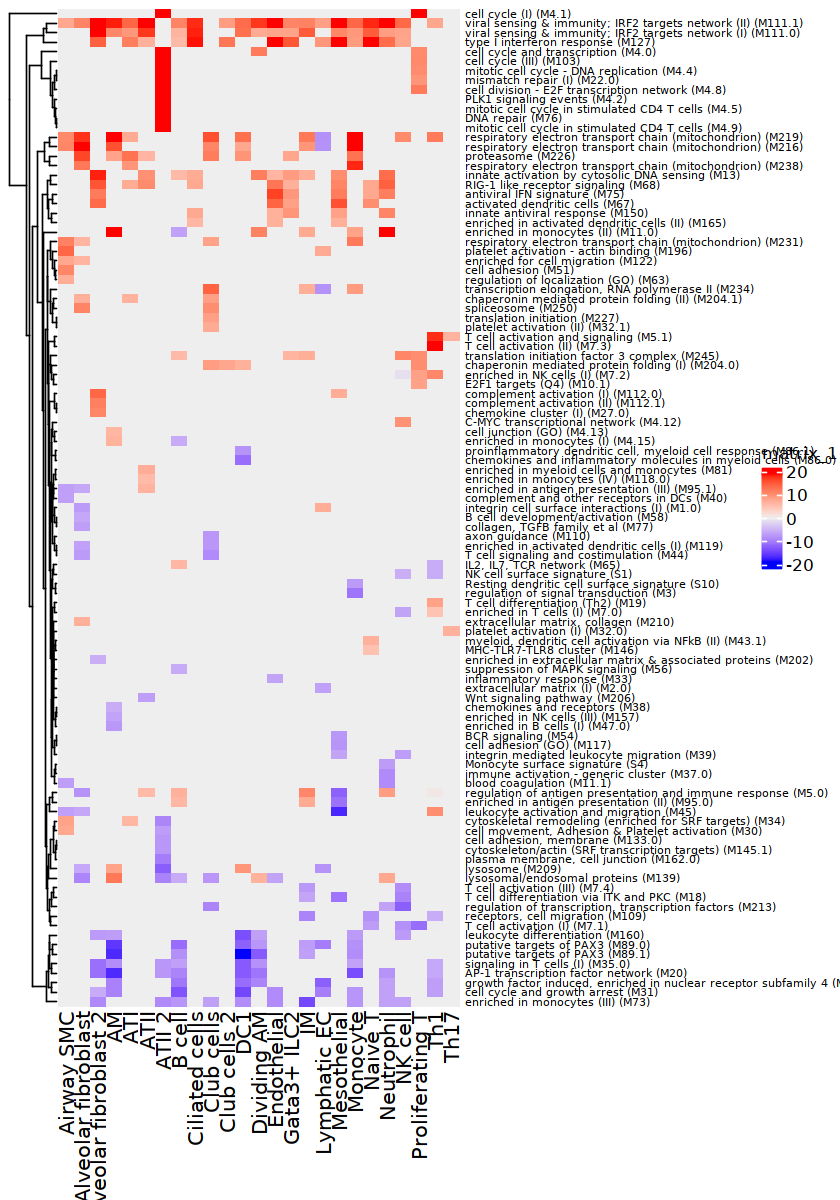

In [26]:
width= 7
height = 10
options(repr.plot.width=width, repr.plot.height=height)
# clust <- hclust(dist(mat %>% as.matrix()))
# all_up_enrich$ID <- factor(all_up_enrich$ID, levels = paths[clust$order]) ## reorder of rows
heaty <- Heatmap(mat, cluster_columns=FALSE, 
                 show_row_names = TRUE,  
                 show_column_names = TRUE, row_names_side = 'right',
                row_names_gp = gpar(fontsize = 6))
heaty = draw(heaty) # draw heatmap
row_order_heaty <- row_order(heaty) # get row BTMs order
# now set the order of 
id_order <- paths[row_order_heaty]
#all_up_enrich$ID <- factor(all_up_enrich$ID, levels = rev(paths[row_order_heaty])) ## reorder of rows

In [27]:
#### Rearranging
# I got this code online and modified it
# I will post a link to the source code when I track it down
# makes pretty ring plots
spot.theme_2 <- list(
  theme_classic(),
  theme(axis.ticks.y=element_blank(), axis.text.y=element_text(size = 10)),
  theme(axis.line=element_blank()),
  theme(text = element_text(size = 10)),
  #theme(axis.title = element_text(size=16)),
  #theme(legend.position = "none"),
  theme(plot.margin = unit(c(10,10,10,10), "mm")),
  #scale_size_continuous(range = c(0.1, 9)),
  scale_x_discrete(position = "top"))

In [28]:
unique(all_up_enrich$clust)

[1] "Alveolar fibroblast"   "Club cells"            "IM"                   
 [4] "ATII"                  "Neutrophil"            "Th17"                 
 [7] "Lymphatic EC"          "Ciliated cells"        "ATII 2"               
[10] "Alveolar fibroblast 2" "Mesothelial"           "Th1"                  
[13] "B cell"                "Endothelial"           "NK cell"              
[16] "Airway SMC"            "DC1"                   "Naive T"              
[19] "AM"                    "Club cells 2"          "Monocyte"             
[22] "Gata3+ ILC2"           "ATI"                   "Dividing AM"          
[25] "Proliferating T"

In [32]:
head(all_up_enrich)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clust,updown,p_inv,pct_in
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
respiratory electron transport chain (mitochondrion) (M216),respiratory electron transport chain (mitochondrion) (M216),9/197,10/2101,4.351665e-09,5.787715e-07,4.809735e-07,Uqcrb/Cox6c/Ndufa7/Ndufb7/Cox7b/Ndufb10/Cox6a1/Ndufs6/Cox7c,9,Alveolar fibroblast,UP Genes,19.25271,0.04568528
respiratory electron transport chain (mitochondrion) (M219),respiratory electron transport chain (mitochondrion) (M219),11/197,17/2101,2.826899e-08,1.879888e-06,1.562234e-06,Uqcrb/Uqcrq/Cox6c/Cox8a/Cox6b1/Cyc1/Cox7b/Cox5b/Cox6a1/Cox7c/Uqcrh,11,Alveolar fibroblast,UP Genes,17.38150,0.05583756
proteasome (M226),proteasome (M226),9/197,12/2101,8.088651e-08,3.585968e-06,2.980029e-06,Psma5/Psmc2/Psma2/Psma3/Psma6/Psma4/Psmd14/Polr2k/Psmc6,9,Alveolar fibroblast,UP Genes,16.33022,0.04568528
respiratory electron transport chain (mitochondrion) (M238),respiratory electron transport chain (mitochondrion) (M238),8/197,13/2101,4.443604e-06,1.477498e-04,1.227838e-04,Ndufa4/Ndufa11/Uqcrq/Ndufb6/Ndufa2/Ndufb2/Ndufs7/Uqcrh,8,Alveolar fibroblast,UP Genes,12.32404,0.04060914
viral sensing & immunity; IRF2 targets network (II) (M111.1),viral sensing & immunity; IRF2 targets network (II) (M111.1),7/197,11/2101,1.370378e-05,3.343470e-04,2.778507e-04,Cxcl10/Zbp1/Bst2/Psmb10/Psmb8/Tnfsf13b/Tap1,7,Alveolar fibroblast,UP Genes,11.19784,0.03553299
spliceosome (M250),spliceosome (M250),6/197,8/2101,1.508332e-05,3.343470e-04,2.778507e-04,Snrpd3/Snrpd1/Magoh/Snrpg/Snrpd2/Lsm5,6,Alveolar fibroblast,UP Genes,11.10192,0.03045685


In [33]:
rev_data_frame %>% filter(ID == "enriched in monocytes (II) (M11.0)")

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clust,updown,p_inv,pct_in
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<fct>,<chr>,<dbl>,<dbl>
enriched in monocytes (II) (M11.0),enriched in monocytes (II) (M11.0),27/191,158/2101,6.432614e-04,1.405986e-02,1.180119e-02,Kynu/Scpep1/Impa2/Ms4a6c/Aif1/Hck/Mndal/Fgl2/Ifi30/Ncf1/Ly86/Blvrb/Fgr/Tns3/Prkcd/Nod2/Spi1/Nlrp3/Cd302/Qpct/Cd86/Ctsh/Plbd1/S100a11/Tyrobp/Fcer1g/Lyn,27,IM,UP Genes,7.348959,0.1413613
enriched in monocytes (II) (M11.0),enriched in monocytes (II) (M11.0),38/166,158/2101,4.460297e-11,5.664577e-09,4.272495e-09,Fcer1g/Mgst1/Cybb/Hck/Aoah/Cyfip1/Nod2/Smpdl3a/Bst1/Fpr2/Cd302/Tns3/Tlr2/Myof/Blvrb/Fcgr1/Pla2g7/Slc31a2/Timp2/Grn/Ms4a6c/Igsf6/Mndal/Ifi30/Clec4a1/Ifngr2/Vnn3/F13a1/Clec4e/Cd86/Aif1/Ctsh/S100a8/Fpr1/Tnfaip2/Csf1r/Ptafr/Ncf1,38,Neutrophil,UP Genes,23.833221,0.2289157
enriched in monocytes (II) (M11.0),enriched in monocytes (II) (M11.0),21/139,158/2101,1.150027e-03,2.012547e-02,1.725040e-02,Cst3/Fcer1g/Tgfbi/Tmem176a/Il13ra1/Plxdc2/Itgam/S100a11/Plbd1/S100a8/Cd36/Timp2/Tyrobp/Syk/Rassf4/Rbm47/Irak3/Grn/Fgr/Ncf2/Spi1,21,B cell,DOWN Genes,-6.767970,0.1510791
enriched in monocytes (II) (M11.0),enriched in monocytes (II) (M11.0),29/119,158/2101,2.904803e-09,1.547792e-07,1.183354e-07,Fpr2/Cybb/Cd1d1/Fcer1g/Ifi30/Mndal/Tnfaip2/Bst1/Fcgr1/Kynu/Blvrb/Ms4a6c/Cd302/Slc31a2/Tgfbi/Ctsh/Hk3/Hck/Tyrobp/Myof/Mgst1/Tnfsf13/Scpep1/Csf1r/Prkcd/Tns3/Aoah/Clec4e/Pla2g7,29,AM,UP Genes,19.656900,0.2436975
enriched in monocytes (II) (M11.0),enriched in monocytes (II) (M11.0),43/208,158/2101,6.483433e-11,3.585202e-09,2.915010e-09,Tnfaip2/Fcer1g/Bst1/Fpr2/Hck/Hk3/Ifi30/Fgl2/Myof/Cybb/Ms4a6c/Blvrb/Pla2g7/Igsf6/Pirb/Aif1/Ncf1/Mndal/Tyrobp/Hpse/Fgr/Aoah/Cd1d1/Cd302/Clec4e/Nod2/Fcgr1/Lst1/Prkcd/Spi1/Tns3/Lat2/Slc15a3/Slc11a1/Slc31a2/Fpr1/Gca/Mgst1/S100a11/Fes/Tgfbi/Tlr2/Sgk1,43,Monocyte,UP Genes,23.459186,0.2067308
enriched in monocytes (II) (M11.0),enriched in monocytes (II) (M11.0),30/223,158/2101,7.392297e-04,1.371682e-02,1.115329e-02,Cd163/Alox5/Stab1/Tmem176a/Pdgfc/Timp2/Kctd12/Cst3/Ms4a7/F13a1/Rtn1/Sulf2/Cd36/Mafb/Klf4/Plxdc2/Rin2/Padi2/Cd14/Csf1r/C5ar1/Cebpa/Nlrp3/Cd93/Cebpd/Cpped1/Cyfip1/Cfp/Il13ra1/Cd86,30,Monocyte,DOWN Genes,-7.209902,0.1345291
enriched in monocytes (II) (M11.0),enriched in monocytes (II) (M11.0),33/207,158/2101,1.102527e-05,4.547926e-04,4.061943e-04,Fpr2/Mndal/Cybb/Mgst1/Tnfaip2/Myof/Fcer1g/Cd1d1/Kynu/Fcgr1/Hck/Cd302/Bst1/Igsf6/Grn/Nod2/Tlr2/Ifi30/S100a8/Csf1r/Cyfip1/Irak3/Blvrb/Tyrobp/Rnf130/Plxnb2/Tgfbi/Pirb/Ncf1/Ms4a6c/Tfec/Pla2g7/Sgk1,33,Dividing AM,UP Genes,11.415321,0.1594203


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


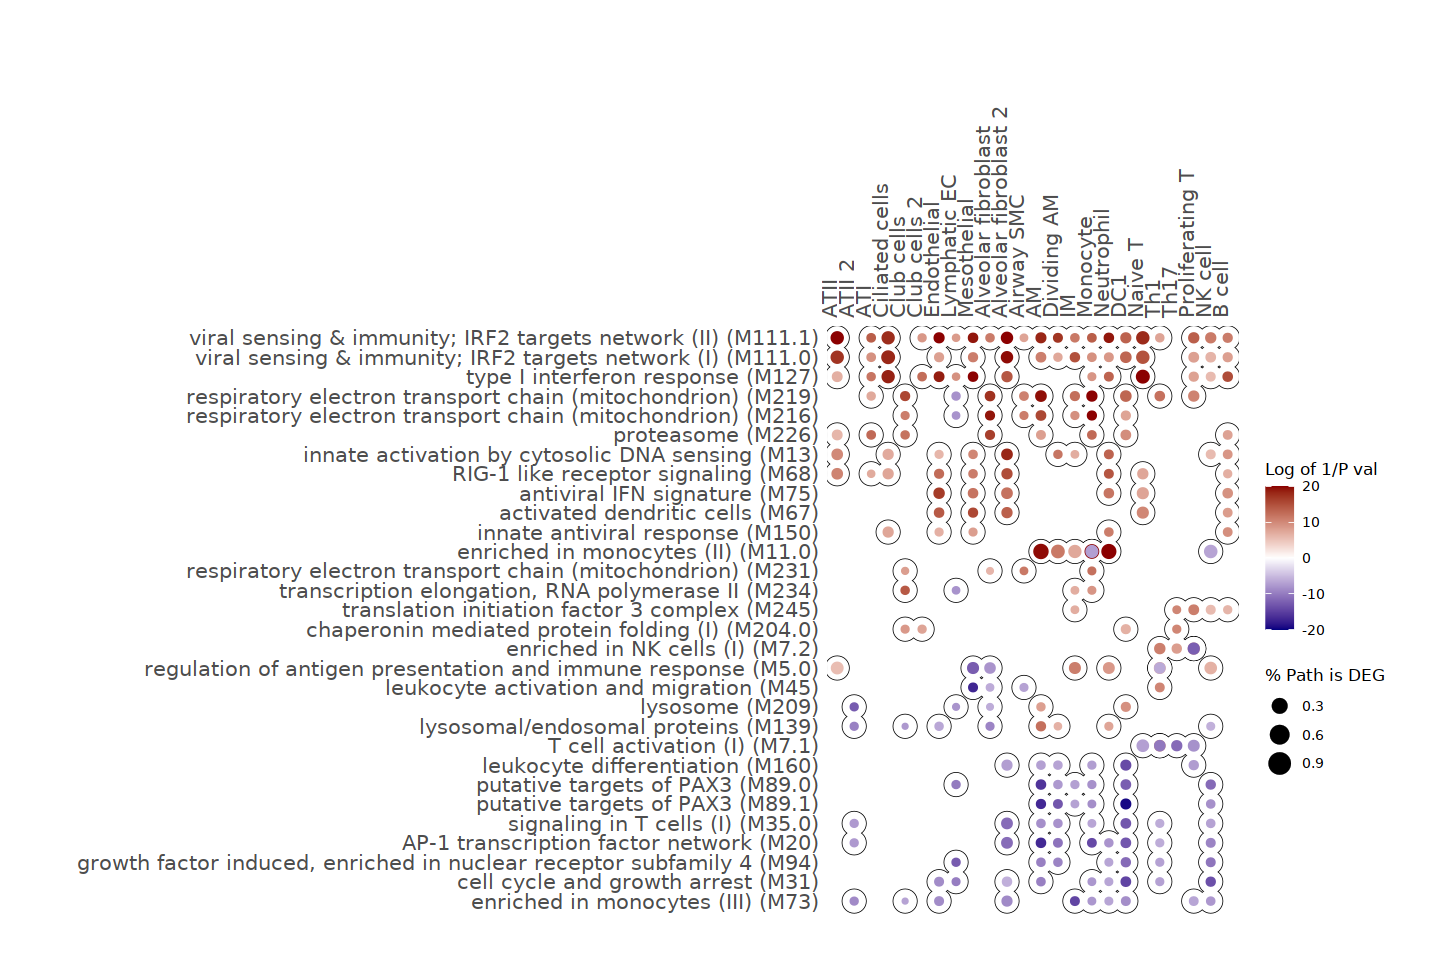

In [29]:
# needs to have columns 
# final_clust_review - cell clusters
# set name - pathway name
# p_inv - 1/p, t-statistic, whatever you want to color by
# pct_in - the percentage of genes in the pathway that are sig, or whatever
# you want the size to be, could be NES, etc
# 
width= 12
height = 8
options(repr.plot.width=width, repr.plot.height=height)

rev_data_frame <- all_up_enrich 
## rev the factor order to better present the results
rev_data_frame$ID <- factor(rev_data_frame$ID, levels = rev(id_order))
## simplify dataframes: at leaset enriched in 2 celltype
show_terms = rev_data_frame %>% group_by(ID) %>% summarise(n=sum(abs(p_inv) > 0)) %>% filter(n > 3) %>% pull(ID)
mask = which(rev_data_frame$ID %in% show_terms)
rev_data_frame = rev_data_frame[mask, ]

## column order
celltype_order <- c("ATII", "ATII 2", "ATI","Ciliated cells","Club cells", "Club cells 2", "Endothelial", "Lymphatic EC", "Mesothelial",
                    "Alveolar fibroblast", "Alveolar fibroblast 2", "Airway SMC","AM", "Dividing AM", "IM","Monocyte","Neutrophil","DC1", 
                    "Naive T", "Th1","Th17","Proliferating T","NK cell","B cell", "Gata3+ ILC2")
rev_data_frame$clust = factor(rev_data_frame$clust, levels = celltype_order)

ring.spot   <- ggplot(rev_data_frame, aes(clust, ID, colour = p_inv)) + 
  scale_color_gradientn(colours=c("navyblue", "white", "darkred"),
                        limits = c(-20,20),
                        oob = scales::squish) +
  labs(size = "% Path is DEG", colour = "Log of 1/P val") + #scale_colour_gradient(low = "pink", high = "black")
  spot.theme_2 + ggtitle("") +
  geom_point(colour = "black",     aes(size = 1.2)) +
  geom_point(colour = "white",     aes(size = 1.0)) +
  geom_point(aes(size = 1.1*pct_in, colour = p_inv)) + ylab("") + xlab("") +
  theme(axis.ticks.x=element_blank(), 
        axis.text.y=element_text(size = 12, face="bold"),
        axis.text.x=element_text(size = 12, angle = 90, hjust = 0, vjust=0, face="bold"), 
        axis.title=element_text(size=16,face="bold"))  +  
  scale_x_discrete(labels=str_replace_all(levels(rev_data_frame$clust), "__", "_"), position = "top")
print(ring.spot)
# ggplot2::ggsave(plot = ring.spot, filename = "BTM_enrichment/BTM_enrich_ringplot_NEW.pdf", 
                # device = 'pdf', width = width, height = height,  units = "in", dpi=300)

In [105]:
unique(degs_updw$celltype)

[1] "Alveolar fibroblast"   "Club cells"            "IM"                   
 [4] "ATII"                  "Neutrophil"            "Th17"                 
 [7] "Lymphatic EC"          "Ciliated cells"        "ATII 2"               
[10] "Alveolar fibroblast 2" "Mesothelial"           "Th1"                  
[13] "B cell"                "Endothelial"           "NK cell"              
[16] "Airway SMC"            "DC1"                   "Naive T"              
[19] "AM"                    "Club cells 2"          "Monocyte"             
[22] "Gata3+ ILC2"           "ATI"                   "Dividing AM"          
[25] "Proliferating T"

In [106]:
# This function is for running hypergeomtric enrichment on many gene sets
runEnrichmentGMT <- function (degs.list, gmt, bg, output ) {
    all_updw_enrich = list()
    for (key in unique(degs_updw$celltype)) {  
       df = degs_updw %>% dplyr::filter(celltype == key)
        print(key)
       df = df[grep("^Rp[sl][[:digit:]]|^Rplp[[:digit:]]|^Rpsa|^mt-", df$gene, invert = T),]
       df$updown <- ifelse(df$avg_log2FC > 0, "UP Genes", "DOWN Genes")
       df_up <- enricher(df[df$updown == "UP Genes", "gene"]$gene, TERM2GENE=gmt, universe=background_gene, minGSSize = 5, maxGSSize = 1000,) 
       df_dw <- enricher(df[df$updown == "DOWN Genes", "gene"]$gene, TERM2GENE=gmt,   universe=background_gene, minGSSize = 5, maxGSSize = 1000,)  
       df_up = as.data.frame(df_up)
       df_dw = as.data.frame(df_dw)
       if (nrow(df_up) > 0) {
           df_up$clust = unique(df$celltype)
           df_up$updown = "UP Genes"
        }
      if (nrow(df_dw) > 0) {
           df_dw$clust = unique(df$celltype)
           df_dw$updown = "DOWN Genes"
       }
       enrich = rbind(df_up, df_dw)
       enrich <- enrich[which(enrich$pvalue < 0.05),]   #get only significant modules
      all_updw_enrich[[key]] = enrich
    }
    all_up_dw_enrich_full <- rbindlist(all_updw_enrich, fill = TRUE)
    # Save df as csv for each gmt
    fwrite(all_up_dw_enrich_full, output)
    ## select top up and down pathways
    all_up_enrich <- all_up_dw_enrich_full %>% group_by(clust, updown) %>% top_n(n = - 20 , wt = pvalue) # -5 -> lowest value in each group
   ## add inverted pvalue and gene ratio column
    all_up_enrich$p_inv <- apply(all_up_enrich, 1,  function (x) { 
        p_inv = log(1/as.numeric(x['pvalue']))
        return(ifelse(x['updown'] == "UP Genes", p_inv, -p_inv))})              
    gene_ratio = str_split_fixed(all_up_enrich$GeneRatio,"/", 2)
    all_up_enrich$pct_in <- as.numeric(gene_ratio[,1]) / as.numeric(gene_ratio[,2])
              
    return(all_up_enrich)
}

In [82]:
Sys.glob("GMT/*mouse.gmt")

[1] "GMT/Azimuth_Cell_Types_2021.mouse.gmt"                      
 [2] "GMT/CellMarker_Augmented_2021.mouse.gmt"                    
 [3] "GMT/DepMap_WG_CRISPR_Screens_Broad_CellLines_2019.mouse.gmt"
 [4] "GMT/DisGeNET.mouse.gmt"                                     
 [5] "GMT/Elsevier_Pathway_Collection.mouse.gmt"                  
 [6] "GMT/GeneSigDB.mouse.gmt"                                    
 [7] "GMT/GO_Biological_Process_2021.mouse.gmt"                   
 [8] "GMT/GO_Molecular_Function_2021.mouse.gmt"                   
 [9] "GMT/HMDB_Metabolites.mouse.gmt"                             
[10] "GMT/Human_Phenotype_Ontology.mouse.gmt"                     
[11] "GMT/KEGG_2019_Mouse.mouse.gmt"                              
[12] "GMT/KEGG_2021_Human.mouse.gmt"                              
[13] "GMT/MSigDB_Hallmark_2020.mouse.gmt"                         
[14] "GMT/Reactome_2022.mouse.gmt"                                
[15] "GMT/WikiPathway_2021_Human.mouse.gmt"

In [114]:
# Run hypergeometric enrichment across all cell types for all gene sets in GMTs
GMTs = c("MSigDB_Hallmark_2020.mouse.gmt", 
         "GO_Biological_Process_2021.mouse.gmt",
         "Reactome_2022.mouse.gmt",
         "KEGG_2021_Human.mouse.gmt",
         "DisGeNET.mouse.gmt")
background_gene = rownames(srt_subset)
background_gene = grep("^Rp[sl][[:digit:]]|^Rplp[[:digit:]]|^Rpsa|^mt-", background_gene, value=T, invert = T)
degs_updw <- fread("lung_fcInf_pctInf_D21vsD0_DEG_allGenes_NEW.csv")

gmt_res_list = list()
for (gmt in GMTs) {
    output = paste0("enrichment_result_other_genesets/", str_replace(gmt, "gmt", "csv"))
    gmt2 = read.gmt(paste0("GMT/", gmt))
    test = runEnrichmentGMT(degs_updw, gmt2, background_gene, output)
    gmt_res_list[[gmt]] = test 
}

[1] "Alveolar fibroblast"
[1] "Club cells"
[1] "IM"
[1] "ATII"
[1] "Neutrophil"
[1] "Th17"
[1] "Lymphatic EC"
[1] "Ciliated cells"
[1] "ATII 2"
[1] "Alveolar fibroblast 2"
[1] "Mesothelial"
[1] "Th1"
[1] "B cell"
[1] "Endothelial"
[1] "NK cell"
[1] "Airway SMC"
[1] "DC1"
[1] "Naive T"
[1] "AM"
[1] "Club cells 2"
[1] "Monocyte"
[1] "Gata3+ ILC2"
[1] "ATI"
[1] "Dividing AM"
[1] "Proliferating T"
[1] "Alveolar fibroblast"
[1] "Club cells"
[1] "IM"
[1] "ATII"
[1] "Neutrophil"
[1] "Th17"
[1] "Lymphatic EC"
[1] "Ciliated cells"
[1] "ATII 2"
[1] "Alveolar fibroblast 2"
[1] "Mesothelial"
[1] "Th1"
[1] "B cell"
[1] "Endothelial"
[1] "NK cell"
[1] "Airway SMC"
[1] "DC1"
[1] "Naive T"
[1] "AM"
[1] "Club cells 2"
[1] "Monocyte"
[1] "Gata3+ ILC2"
[1] "ATI"
[1] "Dividing AM"
[1] "Proliferating T"
[1] "Alveolar fibroblast"
[1] "Club cells"
[1] "IM"
[1] "ATII"
[1] "Neutrophil"
[1] "Th17"
[1] "Lymphatic EC"
[1] "Ciliated cells"
[1] "ATII 2"
[1] "Alveolar fibroblast 2"
[1] "Mesothelial"
[1] "Th1"
[1] "B

In [115]:
summary(gmt_res_list)
head(gmt_res_list$MSigDB_Hallmark_2020.mouse.gmt)

                                     Length Class      Mode
MSigDB_Hallmark_2020.mouse.gmt       13     grouped_df list
GO_Biological_Process_2021.mouse.gmt 13     grouped_df list
Reactome_2022.mouse.gmt              13     grouped_df list
KEGG_2021_Human.mouse.gmt            13     grouped_df list
DisGeNET.mouse.gmt                   13     grouped_df list

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,clust,updown,p_inv,pct_in
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
Oxidative Phosphorylation,Oxidative Phosphorylation,135/1231,194/4127,1.142807e-31,5.714035e-30,4.571228e-30,Hsd17b10/Ndufs3/Ech1/Fdx1/Atp5o/Oat/Htra2/Echs1/Slc25a4/Ndufb4/Cox7a2/Timm10/Timm17a/Mrpl35/Uqcrb/Acadsb/Ndufc1/Ndufa4/Ndufa5/Timm50/Tomm22/Ndufb8/Atp5j2/Etfa/Uqcrq/Surf1/Mrps11/Ndufb3/Ndufb6/AK157302/Acadm/Cox6c/Mrps15/Ndufv2/Timm13/Ndufa7/Ndufb7/Pdhx/Sdhc/Grpel1/Phyh/Idh3b/Atp5j/Cox17/Idh3a/Ndufs2/Etfb/Mrps22/Cox8a/Cox6b1/Ndufs1/Ndufab1/Cyc1/Cox7b/Vdac1/Cox5b/Mrpl34/Idh2/Ndufa2/Mtx2/Prdx3/Cox6a1/Ndufv1/Sdhb/Cox4i1/Gpx4/Atp5h/Nqo2/Atp5c1/Atp6v1g1/Suclg1/Vdac3/Ndufs6/Cycs/Atp5d/Acaa2/Ndufb2/Cyb5a/Polr2f/Mrpl11/Aifm1/Slc25a11/Bckdha/Idh3g/Atp5e/Cox7c/Ndufs7/Atp5k/Acaa1a/Fxn/Rhot2/Acadvl/Atp6v1f/Mdh1/Uqcrc2/Decr1/Bdh2/Atp6v0e/Sdhd/Uqcrfs1/Ndufa8/Mdh2/Got2/Atp6v0c/Gpi1/Ndufa1/Timm9/Sucla2/Mrps12/Pdha1/Mrpl15/Phb2/Vdac2/Eci1/Timm8b/Dld/Cox7a2l/Ndufa3/Uqcrc1/Atp5g3/Slc25a3/Uqcrh/Fh1/Ndufc2/Atp5a1/Mpc1/Pdp1/Atp5g2/Aco2/Uqcr11/Hadha/Atp6v1c1/Atp6v1e1/Uqcr10/Cox15,135,Alveolar fibroblast,UP Genes,71.246650,0.10966694
Interferon Gamma Response,Interferon Gamma Response,108/1231,185/4127,1.452814e-16,3.632036e-15,2.905629e-15,Cxcl9/Cxcl10/Zbp1/Ifit3/Apol6/Batf2/Gbp3/Il18bp/Ifitm3/Isg15/Bst2/Xaf1/Stat1/Gbp4/B2m/Psmb10/Cfb/Psmb9/Ccl7/Ube2l6/Psmb8/Tnfaip2/Irf7/Socs1/Sod2/Ccl2/Sectm1a/Rtp4/Irf1/Ifi44/Tap1/Vcam1/Serping1/C1ra/Pnp/Lgals3bp/Ifnar2/Fas/Wars/Ifi35/Psma2/Psme1/Psma3/Trim21/Lap3/Vamp5/Stat2/Rnf213/Nmi/Cmpk2/Isoc1/Irf9/Sri/Eif4e3/Ifih1/Sp110/Trafd1/Psmb2/Isg20/Cmklr1/Mvp/Nod1/Cd274/Il15ra/Ly6e/Ifit2/Rsad2/Ripk2/Sspn/Mthfd2/Casp3/Myd88/Socs3/Znfx1/Lysmd2/Eif2ak2/Nampt/Upp1/Ido1/Ddx58/Oas2/Ripk1/Arl4a/Samhd1/Lats2/Ptpn1/Rbck1/Il7/Pml/Herc6/Sppl2a/Il6/Cd40/Parp12/Samd9l/Trim26/Psme2b/Tapbp/Helz2/Parp14/Irf8/Il4ra/Cmtr1/H2-DMa/Txnip/Tnfaip6/Arid5b/Pla2g4a,108,Alveolar fibroblast,UP Genes,36.467859,0.08773355
Myc Targets V1,Myc Targets V1,106/1231,182/4127,3.579603e-16,5.966005e-15,4.772804e-15,Psma2/Srm/Psmd7/Psma7/Snrpd3/Ran/Eif4e/Pole3/Hddc2/Aimp2/Psmd8/Psmb3/Psma6/Bub3/Ssb/Snrpd1/Psma4/Psmd14/Psma1/Hdac2/Ssbp1/Lsm2/Psmb2/Eif2s2/Gspt1/Pabpc4/Eif2s1/C1qbp/Ndufab1/Cyc1/Vdac1/Eif1ax/Nap1l1/Txnl4a/Nop16/Ddx18/Prdx4/Rsl1d1/Acp1/Erh/Prdx3/Tfdp1/Kars/Hsp90ab1/Ppia/Cct2/Ywhaq/Vdac3/Snrpg/Ywhae/Ptges3/Psmc6/Snrpa/Vbp1/Nme1/Snrpd2/Snrpb2/Ube2e1/Npm1/Tcp1/Eif3d/Prpf31/Gnl3/Mcm4/Ube2l3/Glo1/Rfc4/Rack1/Cct5/Iars/Mrps18b/Cops5/Snrpa1/Got2/Cdk4/Cct3/Ap3s1/U2af1/Ncbp2/Psmc4/Ranbp1/Eif4h/Nolc1/Ctps/Phb2/Pgk1/Eef1b2/Srpk1/Srsf7/Xpot/Pcbp1/Pa2g4/Slc25a3/Dek/Hspe1-rs1/Rad23b/Serbp1/Eif3j1/Mrpl23/Srsf3/Fbl/Srsf2/Rrp9/Pcna/Mrpl9/Hnrnpu,106,Alveolar fibroblast,UP Genes,35.566110,0.08610885
Interferon Alpha Response,Interferon Alpha Response,53/1231,89/4127,3.951925e-09,4.939906e-08,3.951925e-08,Cxcl10/Ifit3/Batf2/Gbp3/Ifitm3/Isg15/Bst2/B2m/Psmb9/Ube2l6/Psmb8/Irf7/Tmem140/Rtp4/Irf1/Ifi44/Tap1/Lgals3bp/Wars/Ifi35/Psme1/Psma3/Csf1/Trim21/Lap3/Stat2/Nmi/Cmpk2/Irf9/Ifih1/Sp110/Trafd1/Parp9/Mvb12a/Isg20/Ly6e/Ifit2/Rsad2/Ripk2/Lpar6/Eif2ak2/Il7/Herc6/Parp12/Samd9l/Trim26/Psme2b/Helz2/Parp14/Procr/Il4ra/Cmtr1/Txnip,53,Alveolar fibroblast,UP Genes,19.349063,0.04305443
Adipogenesis,Adipogenesis,91/1231,196/4127,3.785146e-07,3.785146e-06,3.028116e-06,Tst/Mrap/Ndufs3/Ech1/Hspb8/Atp5o/Cd151/Echs1/Cdkn2c/Gpx3/Hadh/Scp2/Cd302/Ndufa5/Uqcrq/Cmbl/Aldh2/C3/Acadm/Ndufb7/Nmt1/Sdhc/Vegfb/Grpel1/Phyh/Jagn1/Idh3a/Apoe/Etfb/Cox8a/Itsn1/Dnajb9/Ndufab1/Nkiras1/Cyc1/Cox7b/Uck1/Rnf11/Prdx3/Cox6a1/Sparcl1/Acads/Sdhb/Sspn/Gpx4/Coq9/Ccng2/Suclg1/Fah/Ephx2/Acaa2/Ptcd3/Ubc/Aifm1/Bckdha/Idh3g/Omd/Sult5a1/Angptl4/Ddt/Acadl/Arl4a/Decr1/Qdpr/Dbt/G3bp2/Slc25a10/Abcb8/Dhrs7b/Agpat3/Mdh2/Gpam/Mtch2/Mrpl15/Cmpk1/Ak2/Dld/Rmdn3/Pfkl/Uqcrc1/Aldoa/Taldo1/Aco2/Uqcr11/Mylk/Phldb1/Coq5/Reep5/Uqcr10/Ptger3/Elovl6,91,Alveolar fibroblast,UP Genes,14.787011,0.07392364
DNA Repair,DNA Repair,63/1231,145/4127,2.765842e-04,2.304869e-03

[1] 26 25 34 31 13 18
[1]   5  82 211  88 212  87


The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



[1] 114  27  28 208 216 129
[1] 102 116 115  65   9  97


The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



[1] 170   5 142 130 131 111


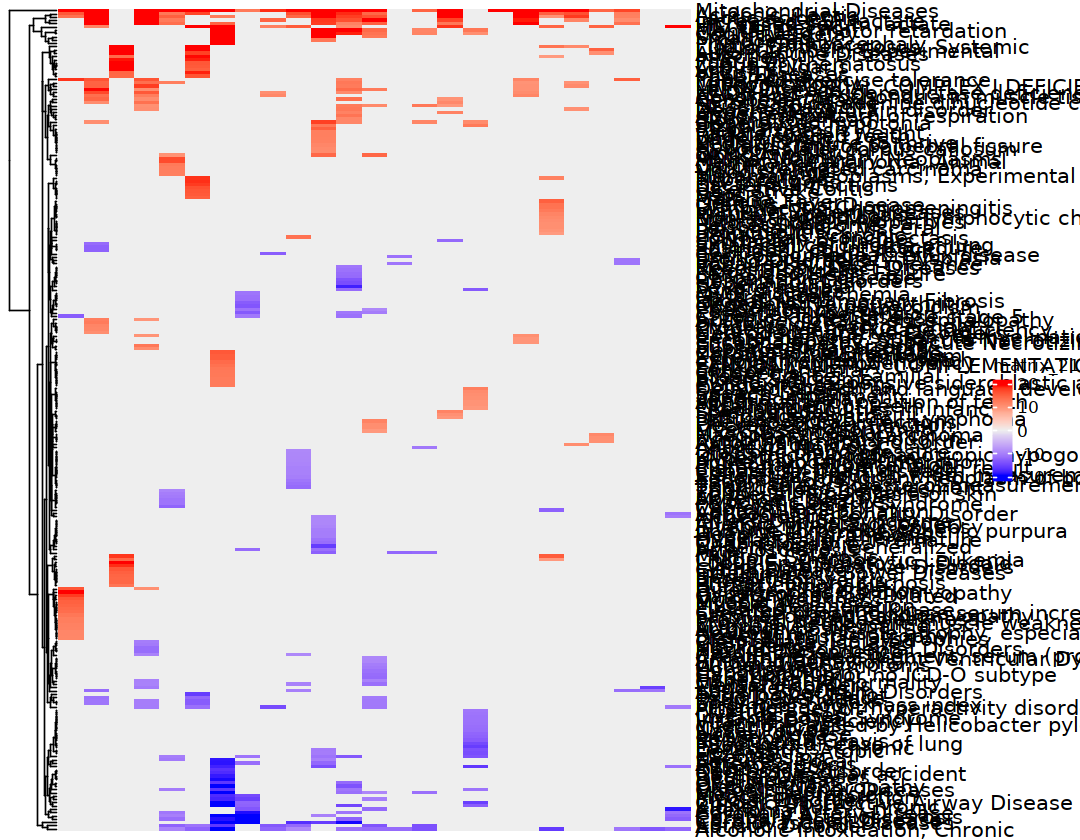

In [116]:
# Get row order for ringplot by clustering rows with Heatmap first

row_order_list = lapply(gmt_res_list,  function(df) {
    ## cluster_rows
    all_up_enrich_sub <- subset(df, select = c("clust", "ID", "p_inv"))
    mat <- reshape2::dcast(all_up_enrich_sub, formula = ID ~ clust, 
                                value.var = "p_inv", 
                                fun.aggregate = mean,
                                fill = 0)
    paths = mat$ID
    mat <- as.matrix(mat[,-1]) #drop ID column as now in rows
    rownames(mat) = paths
    heaty <- Heatmap(mat, cluster_columns=FALSE, 
                     show_row_names = TRUE, 
                     show_column_names = FALSE, row_names_side = 'right')
    heaty = draw(heaty) # draw heatmap
    row_order_heaty <- row_order(heaty) # get row BTMs order
    print(head(row_order_heaty))
    # now set the order of 
    id_order <- paths[row_order_heaty]
    return(id_order)
})

In [117]:
summary(row_order_list)

                                     Length Class  Mode     
MSigDB_Hallmark_2020.mouse.gmt        46    -none- character
GO_Biological_Process_2021.mouse.gmt 220    -none- character
Reactome_2022.mouse.gmt              218    -none- character
KEGG_2021_Human.mouse.gmt            164    -none- character
DisGeNET.mouse.gmt                   250    -none- character

In [ ]:
## Testing 1 result from gmt_res_list 
# df <- gmt_res_list$MSigDB_Hallmark_2020.mouse.gmt
# all_up_enrich_sub <- subset(df, select = c("clust", "ID", "p_inv"))
#     mat <- reshape2::dcast(all_up_enrich_sub, formula = ID ~ clust, 
#                                 value.var = "p_inv", 
#                                 fun.aggregate = mean,
#                                 fill = 0)
#     paths = mat$ID
# mat <- as.matrix(mat[,-1]) #drop ID column as now in rows
#     rownames(mat) = paths
# heaty <- Heatmap(mat, cluster_columns=FALSE, 
#                      show_row_names = TRUE, 
#                      show_column_names = TRUE, row_names_side = 'right')
#     heaty = draw(heaty) # draw heatmap
#     row_order_heaty <- row_order(heaty) # get row BTMs order
#     print(head(row_order_heaty))
#     # now set the order of 
#     id_order <- paths[row_order_heaty]
# id_order

In [118]:
# Function for plotting ringplot
# needs to have columns 
# final_clust_review - cell clusters
# set name - pathway name
# p_inv - 1/p, t-statistic, whatever you want to color by
# pct_in - the percentage of genes in the pathway that are sig, or whatever
# you want the size to be, could be NES, etc
# column of ringplot is named "clust" in df
# row of ringplot is named "ID" in df
    
width= 12
height = 8
options(repr.plot.width=width, repr.plot.height=height)

drawRingSpot <- function (df, output, row_order, column_order, num_sig=1, width=12, height=8) {
    rev_data_frame <- df 
    rev_data_frame$ID <- factor(rev_data_frame$ID, levels = row_order)
    ## simplify dataframes: at leaset enriched in 2 celltype
    show_terms = rev_data_frame %>% group_by(ID) %>% summarise(n=sum(abs(p_inv) > 0)) %>% filter(n > 3) %>% pull(ID)
    mask = which(rev_data_frame$ID %in% show_terms)
    rev_data_frame = rev_data_frame[mask, ]
    rev_data_frame$clust = factor(rev_data_frame$clust, levels = column_order)

    ring.spot   <- ggplot(rev_data_frame, aes(clust, ID, colour = p_inv)) + 
      scale_color_gradientn(colours=c("navyblue", "white", "darkred"),
                            limits = c(-20,20),
                            oob = scales::squish) +
      labs(size = "% Path is DEG", colour = "Log of 1/P val") + #scale_colour_gradient(low = "pink", high = "black")
      spot.theme_2 + ggtitle("") +
      geom_point(colour = "black",     aes(size = 1.2)) +
      geom_point(colour = "white",     aes(size = 1.0)) +
      geom_point(aes(size = 1.1*pct_in, colour = p_inv)) + ylab("") + xlab("") +
      theme(axis.ticks.x=element_blank(), 
            axis.text.y=element_text(size = 12, face="bold"),
            axis.text.x=element_text(size = 12, angle = 90, hjust = 0, vjust=0, face="bold"), 
            axis.title=element_text(size=16,face="bold"))  +  
      scale_x_discrete(labels=str_replace_all(column_order, "__", "_"), position = "top")
    print(ring.spot)
    ggplot2::ggsave(plot = ring.spot, filename = output,
                    device = 'pdf', width = width, height = height,  units = "in", dpi=300)

}

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


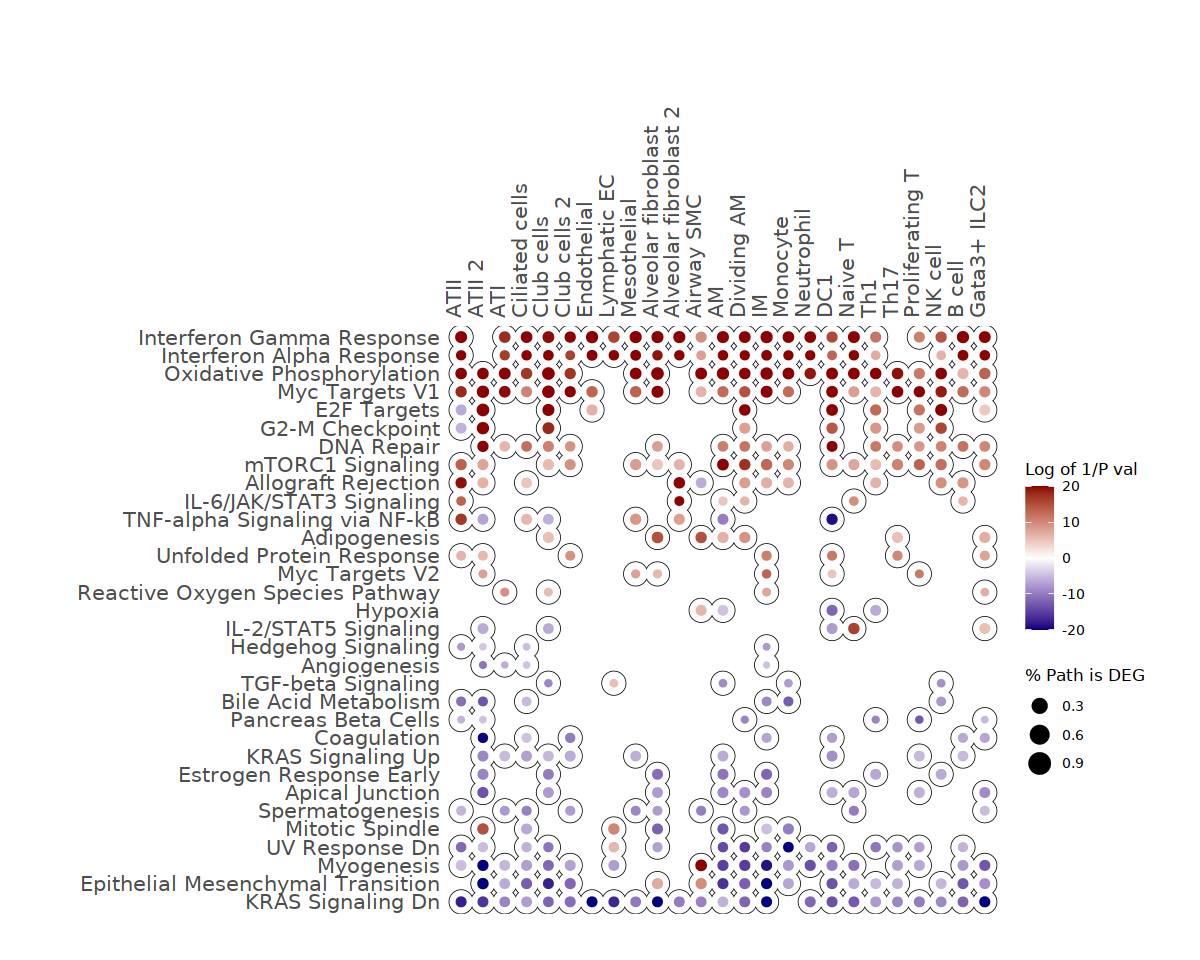

In [140]:
width= 10
height = 8
options(repr.plot.width=width, repr.plot.height=height)

## column order
celltype_order <- c("ATII", "ATII 2", "ATI","Ciliated cells","Club cells", "Club cells 2", "Endothelial", "Lymphatic EC", "Mesothelial",
                    "Alveolar fibroblast", "Alveolar fibroblast 2", "Airway SMC","AM", "Dividing AM", "IM","Monocyte","Neutrophil","DC1", 
                    "Naive T", "Th1","Th17","Proliferating T","NK cell","B cell", "Gata3+ ILC2")

name = "MSigDB_Hallmark_2020.mouse.gmt"
drawRingSpot(df = gmt_res_list[[name]], 
                          output = paste0("enrichment_result_other_genesets/", name, ".pdf"), 
                          row_order = rev(row_order_list[[name]]), 
                          column_order = celltype_order, 
                          num_sig=3, width=width, height=height)

In [2]:
dim(srt_subset)

[1] 32285 28308

In [5]:
metadata <- srt_subset@meta.data
umapcoords <- as.data.frame(Embeddings(object = srt_subset[["umap"]]))
metadata <- cbind(metadata, umapcoords) 

In [29]:
fwrite(metadata, file="srt_subset_lung_metadata_AL.csv")

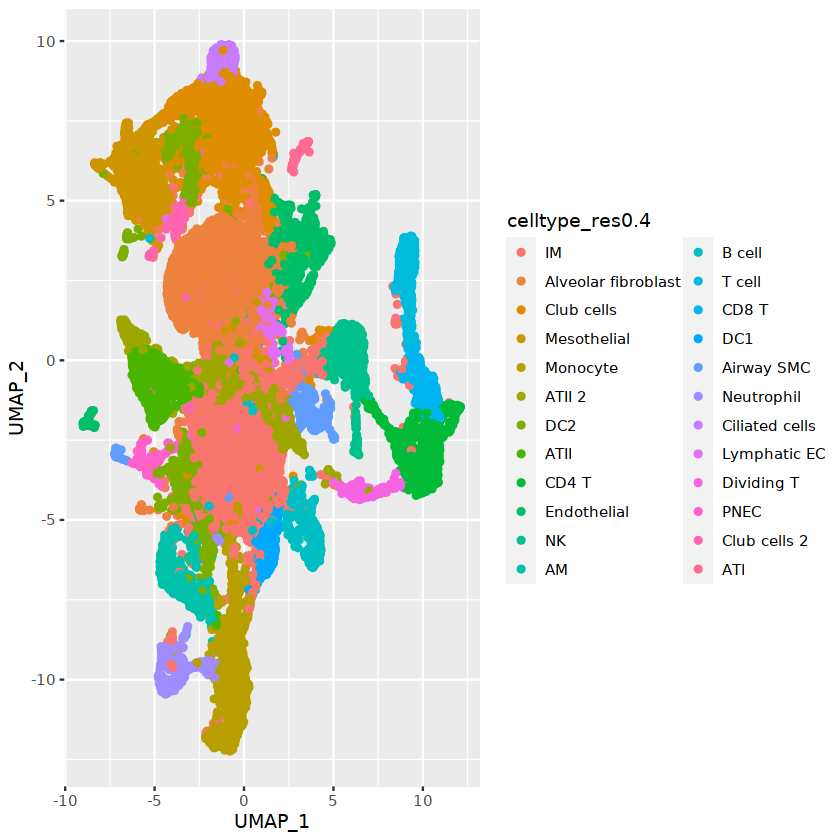

In [28]:
ggplot(aes(x=UMAP_1, y=UMAP_2, color=celltype_res0.4), data=metadata) + geom_point()